# Project 3

1. Design an RSLQR to track a constant airspeed command and a constant angle-of-attack
command;
2. Design an RSLQR to track a constant roll angle command;
3. Simulate the linear airplane dynamics with the decoupled control systems with a step response
on the command

In [189]:
from typing import *

import numpy as np
from scipy.integrate import solve_ivp
import scipy.linalg as la
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from control import StateSpace
from control import lqr
from control.matlab import lsim, step

pio.templates.default = "ggplot2"
pio.renderers.default = "jupyterlab"

### Creating the LTI State Space Model

In [253]:
class Plane:
    MAX_STEP = 0.1

    def __init__(self, ) -> None:
        self.A = np.array([
            [-0.038, 18.984, 0, -32.174, 0, 0, 0, 0],
            [-0.001, -0.632, 1, 0, 0, 0, 0, 0],
            [0, -0.759, -0.518, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, -0.0829, 0, -1, 0.0487],
            [0, 0, 0, 0, -4.546, -1.699, 0.1717, 0],
            [0, 0, 0, 0, 3.382, -0.0654, -0.0893, 0],
            [0, 0, 0, 0, 0, 1, 0, 0]
        ])

        self.B = np.array([
            [0, 10.1, 0, 0],
            [-0.0086, 0, 0, 0],
            [-0.011, 0.025, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0.0116],
            [0, 0, 27.276, 0.5758],
            [0, 0, 0.3952, -1.362],
            [0, 0, 0, 0],
        ])

        self.Q = np.eye(self.A.shape[0])

        self.R = np.eye(self.B.shape[1]) * 0.01

        self.u_bar = 250  # ft/s

        self.x0 = np.array(
            [250, 0, 0, 0, 0, 0, 0, 0]
        )
    
    
    
    def matlab_try(self, target_matrix: np.ndarray) -> np.ndarray:
        A = np.r_[np.c_[self.A, np.zeros(self.A.shape[0])], [[1, 0, 0, 0, 0, 0, 0, 0, 0]]]
        B = np.r_[self.B, [[0] * self.B.shape[1]]]
        C = np.eye(A.shape[0])
        D = 0

        Q = np.diag([10, 10, 10, 10, 10, 10, 10, 10, 10])
        
        K, _, _ = lqr(A, B, Q, self.R)

        if target_matrix.shape[0] != B.shape[0]:
            target_matrix = np.append(target_matrix, [0])

        Aaug = A-B@K
        Baug = B@K@target_matrix - target_matrix

        _ss = StateSpace(Aaug, Baug.T, C, 0)

        return step(_ss, T=np.linspace(0, 10, 1000), X0=np.append(self.x0, [0]))

    
    def build_aug_matrixes(self, target_matrix: np.ndarray) -> np.ndarray:
        a_stack = np.vstack((np.zeros(self.A.shape[0]) + 1 * (target_matrix != 0), self.A))         
        self.augA = np.hstack((np.zeros((a_stack.shape[0], 1), dtype=a_stack.dtype), a_stack, ))
        self.augB = np.vstack((np.zeros(self.B.shape[1]), self.B))
        self.augC = np.zeros(self.augA.shape[0]) + -1
#         self.augC[0] = -1
        self.augQ = np.eye(self.augA.shape[0])

    def K_rslqr(self, ) -> np.ndarray:
        X = np.matrix(
            la.solve_continuous_are(
                self.augA, self.augB, self.augQ, self.R, e=None, balanced=True
            )
        )

        self.augK = np.matrix(la.inv(self.R) @ (self.augB.T * X))

        return self.augK

    def optimal_f(self, target_matrix) -> object:
        
        A = np.r_[np.c_[self.A, np.zeros(self.A.shape[0])], [[1, 0, 0, 0, 0, 0, 0, 0, 0]]]
        B = np.r_[self.B, [[0] * self.B.shape[1]]]
        C = np.eye(A.shape[0])
        D = 0
        Q = np.diag([10, 10, 10, 10, 10, 10, 10, 10, 10])
        K, _, _ = lqr(A, B, Q, self.R)

        if target_matrix.shape[0] != B.shape[0]:
            target_matrix = np.append(target_matrix, [0])

        Aaug = A-B@K
#         Baug = B@K@target_matrix - target_matrix
        Baug = - (target_matrix - np.append(self.x0, [0]))

        def f(t, x_t, wr):
            # calling extra np array function here is dumb
#             U = np.array(-1 * self.augK @ (x_t))[0]
#             return self.augA @ x_t + (self.augB @ U.T)
            return np.array(((Aaug @ (x_t - wr).T) + Baug))[0]
        return f

    def augA(self, ) -> np.ndarray:
        self.A
    
    @property
    def ss(self, ) -> StateSpace:
        return StateSpace(self.A, self.B, np.eye(self.A.shape[0]), np.zeros(self.B.shape))

    def simulate_uncontrolled(self, t_vect: np.ndarray, u_vect: np.ndarray, ) -> Tuple[np.ndarray]:
        self.T = t_vect
        self.U = u_vect
        return solve_ivp(self._f(), y0=self.x0, t_span=(t_vect[0], t_vect[-1]), max_step=Plane.MAX_STEP, args=(None, ))
#         return lsim(self.ss, u_vect, t_vect, self.x0)

    def simulate_controlled(self, t_vect: np.ndarray, wr: np.ndarray, K: np.ndarray = None) -> Tuple[np.ndarray]:
        # this is a bad practive but getting lazy
        # self.augK = K
        # initialize x0 with the error term
        augx0 = np.append(self.x0, [0])
        # target 0 error
        wr = np.append(wr, [0])
        return solve_ivp(self.optimal_f(wr), y0=augx0, t_span=(t_vect[0], t_vect[-1]), max_step=Plane.MAX_STEP, args=(wr, ))

    def _f(self, ):
        def f(t, x_t, wr):
            U = np.array(-1 * self.K @ (x_t - wr))[0] if wr is not None else np.array(self.step_function(t))
            return self.A @ x_t + (self.B @ U.T)
        return f

    def step_function(self, t: float):
        return self.U[int(t // ((self.T[-1] - self.T[0]) / len(self.U)))]

    def design_lrq(self, ) -> None:
        X = np.matrix(
            la.solve_continuous_are(
                self.A, self.B, self.Q, self.R, e=None, balanced=True)
        )

        # compute the LQR gain
        self.K = np.matrix(la.inv(self.R) @ (self.B.T * X))

        return self.K

    def control_lqr(self, ) -> np.ndarray:
        # This function is used as a check of my own LQR implementation
        from control import lqr

        return lqr(self.ss, self.Q, self.R)

    def plot(self, t: np.ndarray, y: np.ndarray, u: np.ndarray, flat: bool = True) -> None:
        fig = make_subplots(rows=5,
                            cols=1,
                            shared_xaxes=True,
                            vertical_spacing=0.05,
                            subplot_titles=("Airspeed",
                                            "Angular Velocity",
                                            "Angles",
                                            "Control Surface Deflection",
                                            "Thrust",
                                            )
                            )

        for j, (data, yaxis_title, inner_settings) in enumerate(
            [[y, "ft/s", [["u", 0]]],
             [y, "rad/s", [["q", 2], ["r", 6], ["p", 5]]],
             [y, "rad", [["phi", 7], ["theta", 3], [
                 "beta", 4], ["beta", 4], ["alpha", 4]]],
             [u, "rad", [["elevator", 0], ["airlerons", 2], ["rudder", 3]]],
             [u, "lbs", [["thrust", 1]]],
             ]
        ):
            for name, ind in inner_settings:
                fig.add_trace(go.Scatter(
                    x=t,
                    #                     y=[val[ind] + self.u_bar if j < 1 else val[ind] for val in data],
                    y=data[ind] if flat else [val[ind] for val in data],
                    name=name
                ),
                    row=j + 1, col=1
                )

            update_dict = {
                f"yaxis{j+1}" if j > 0 else "yaxis": dict(title=yaxis_title)
            }
            fig.update_layout(update_dict)
        fig.update_layout(
            height=800
        )

        fig.show()

## Simulate the linear airplane dynamics with the decoupled control systems with a step response on the command

In [317]:
p = Plane()

----
$[u, v, w]$ = linear velocity $ft/s$

$[p, q, r]$ = angular velocity $rad/s$

$[\phi, \theta, \psi]$ = Euler angles $rad$

$\alpha$ = angles of attack $rad$

$\beta$ = sideslip angle $rad$

---

$\delta_a$ = control surface deflection airlerons

$\delta_e$ = control surface deflection elevator

$\delta_r$ = control surface deflection rudder

$\delta_t$ = propeller thrust

### Thrust

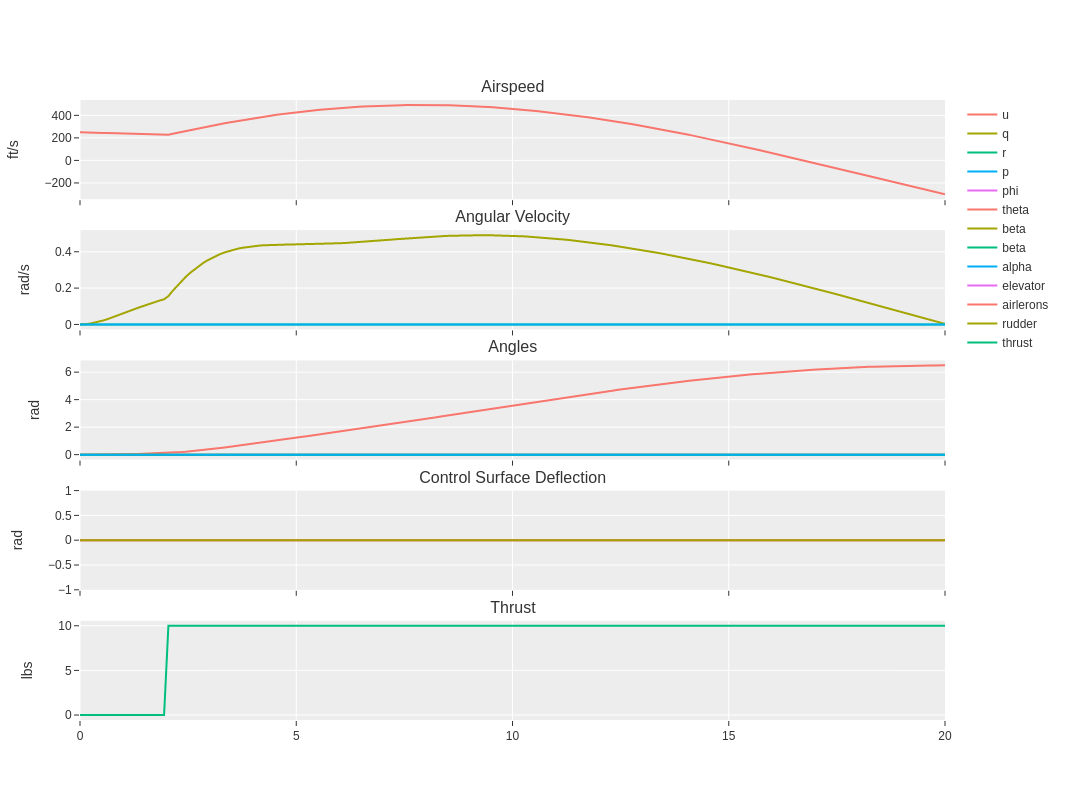

In [318]:
u = np.array([[0, 0, 0, 0]] * 10 + [[0, 10, 0, 0]] * 90)
res = p.simulate_uncontrolled(np.linspace(0, 20, 100), u)
p.plot(res.t, res.y, [[p.step_function(_t)[i] for _t in res.t] for i in range(4)], flat=True)
# res.y

### Elevator

In [5]:
u = np.array([[0, 0, 0, 0]] * 10 + [[1, 0, 0, 0]] * 90)
res = p.simulate_uncontrolled(np.linspace(0, 20, 100), u)
p.plot(res.t, res.y, [[p.step_function(_t)[i] for _t in res.t] for i in range(4)], flat=True)

### Airlerons

In [6]:
u = np.array([[0, 0, 0, 0]] * 10 + [[0, 0, 1, 0]] * 90)
res = p.simulate_uncontrolled(np.linspace(0, 20, 100), u)
p.plot(res.t, res.y, [[p.step_function(_t)[i] for _t in res.t] for i in range(4)], flat=True)

### Rudder

In [7]:
u = np.array([[0, 0, 0, 0]] * 10 + [[0, 0, 0, 1]] * 90)
res = p.simulate_uncontrolled(np.linspace(0, 20, 100), u)
p.plot(res.t, res.y, [[p.step_function(_t)[i] for _t in res.t] for i in range(4)], flat=True)

## Design an RSLQR to track a constant airspeed command and a constant angle-of-attack command

In [337]:
desired_operating_point = np.array([275, 0, 0, 0, 0, 0, 0, 0])

In [338]:
p = Plane()

In [340]:
p.R = np.diag([75, 75, 75, 75])

In [341]:
p.Q[0, 0] = 100
# p.R = np.eye(p.R.shape[1]) * 0.05 

In [342]:
y, t = p.matlab_try(desired_operating_point)

In [343]:
p.build_aug_matrixes(desired_operating_point)
K = p.K_rslqr()

In [344]:
# t, y, _ = p.simulate_controlled(t_vect=np.linspace(0, 20, 100), K=K, wr=desired_operating_point)
res = p.simulate_controlled(t_vect=np.linspace(0, 20, 100), K=K, wr=desired_operating_point)

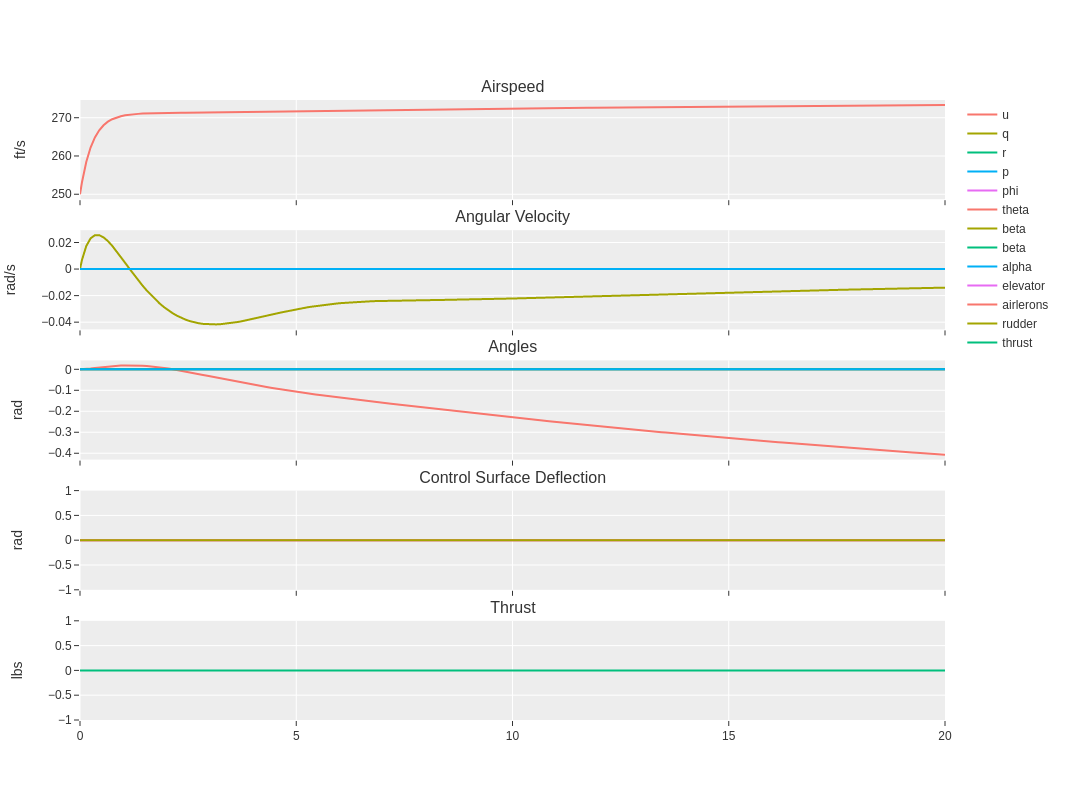

In [345]:
p.plot(res.t, res.y[:-1], [[0 for _t in res.t] for i in range(4)], flat=True)
# p.plot(t, [[_y[ind][0] for _y in y] for ind in range(8)], [[0 for _t in t] for i in range(4)], flat=False)

In [220]:
# [[_y[ind][0] for _y in y] for ind in range(8)]